# Flight Delay Prediction - Exploratory Data Analysis (EDA) and Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os
import glob

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. Load Data

In [2]:
# Load all dataset files
data_files = glob.glob('dataset/Combined_Flights_*.csv')
print(f"Found {len(data_files)} dataset files: {data_files}")

dataframes = []
for file in data_files:
    print(f"Loading {file}...")
    try:
        df_temp = pd.read_csv(file)
        dataframes.append(df_temp)
    except Exception as e:
        print(f"Error loading {file}: {e}")

if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    print(f"All data loaded. Total shape: {df.shape}")
else:
    print("No data loaded. Please generate the dataset first.")

Found 7 dataset files: ['dataset\\Combined_Flights_2018.csv', 'dataset\\Combined_Flights_2019.csv', 'dataset\\Combined_Flights_2020.csv', 'dataset\\Combined_Flights_2021.csv', 'dataset\\Combined_Flights_2022.csv', 'dataset\\Combined_Flights_2023.csv', 'dataset\\Combined_Flights_2024.csv']
Loading dataset\Combined_Flights_2018.csv...
Loading dataset\Combined_Flights_2019.csv...


Loading dataset\Combined_Flights_2020.csv...
Loading dataset\Combined_Flights_2021.csv...


Loading dataset\Combined_Flights_2022.csv...
Loading dataset\Combined_Flights_2023.csv...


Loading dataset\Combined_Flights_2024.csv...
All data loaded. Total shape: (105000, 61)


## 2. Understanding the Data

In [3]:
display(df.head())

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2018-07-20,AirAsia,KUL,SDK,0,0,637,639,2,2,...,0,0,10,816,6,0,0,NaN,0,0
1,2018-12-11,Malaysia Airlines,MEL,KUL,0,0,752,814,22,22,...,0,0,10,2038,28,1,0,NaN,0,0
2,2018-04-20,Scoot,TWU,KUL,0,0,918,918,0,0,...,0,0,10,1200,-1,0,0,NaN,0,0
3,2018-06-02,Singapore Airlines,MYY,KUL,0,0,1615,1615,0,0,...,0,0,10,1810,-4,0,0,NaN,0,0
4,2018-02-03,Scoot,PEN,DOH,0,0,1229,1242,13,13,...,0,0,10,2221,22,1,0,NaN,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 61 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   FlightDate                               105000 non-null  object 
 1   Airline                                  105000 non-null  object 
 2   Origin                                   105000 non-null  object 
 3   Dest                                     105000 non-null  object 
 4   Cancelled                                105000 non-null  int64  
 5   Diverted                                 105000 non-null  int64  
 6   CRSDepTime                               105000 non-null  int64  
 7   DepTime                                  105000 non-null  int64  
 8   DepDelayMinutes                          105000 non-null  int64  
 9   DepDelay                                 105000 non-null  int64  
 10  ArrTime                         

In [5]:
display(df.describe())

,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
count,105000.000000,105000.000000,105000.000000,105000.000000,105000.000000,105000.000000,105000.0,105000.000000,105000.000000,105000.000000,...,105000.0,105000.0,105000.0,105000.00000,105000.000000,105000.000000,105000.0,0.0,105000.0,105000.0
mean,0.010400,0.005152,1180.834171,1168.045543,14.379686,14.379686,0.0,15.827410,256.462714,276.462714,...,0.0,0.0,10.0,1176.81841,14.359010,0.293600,0.0,NaN,0.0,0.0
std,0.101449,0.071595,693.946715,700.540666,25.493353,25.493353,0.0,25.110176,224.662532,224.662532,...,0.0,0.0,0.0,691.70438,26.171028,0.455413,0.0,NaN,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,25.000000,45.000000,...,0.0,0.0,10.0,0.00000,-10.000000,0.000000,0.0,NaN,0.0,0.0
25%,0.000000,0.000000,558.000000,547.000000,0.000000,0.000000,0.0,0.000000,82.000000,102.000000,...,0.0,0.0,10.0,559.00000,-1.000000,0.000000,0.0,NaN,0.0,0.0
50%,0.000000,0.000000,1201.000000,1153.000000,0.000000,0.000000,0.0,6.000000,145.000000,165.000000,...,0.0,0.0,10.0,1155.00000,6.000000,0.000000,0.0,NaN,0.0,0.0
75%,0.000000,0.000000,1802.000000,1758.000000,20.000000,20.000000,0.0,20.000000,425.000000,445.000000,...,0.0,0.0,10.0,1757.00000,20.000000,1.000000,0.0,NaN,0.0,0.0
max,1.000000,1.000000,2359.000000,2359.000000,382.000000,382.000000,0.0,372.000000,780.000000,800.000000,...,0.0,0.0,10.0,2359.00000,372.000000,1.000000,0.0,NaN,0.0,0.0


## 3. Data Cleaning

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Drop duplicates if any
duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicates removed.")

Missing Values:
 OriginState        105000
OriginStateName    105000
DestState          105000
DestStateName      105000
DepTimeBlk         105000
ArrTimeBlk         105000
dtype: int64



Duplicate Rows: 0


## 4. Exploratory Data Analysis (EDA)

### Flight Delays Analysis

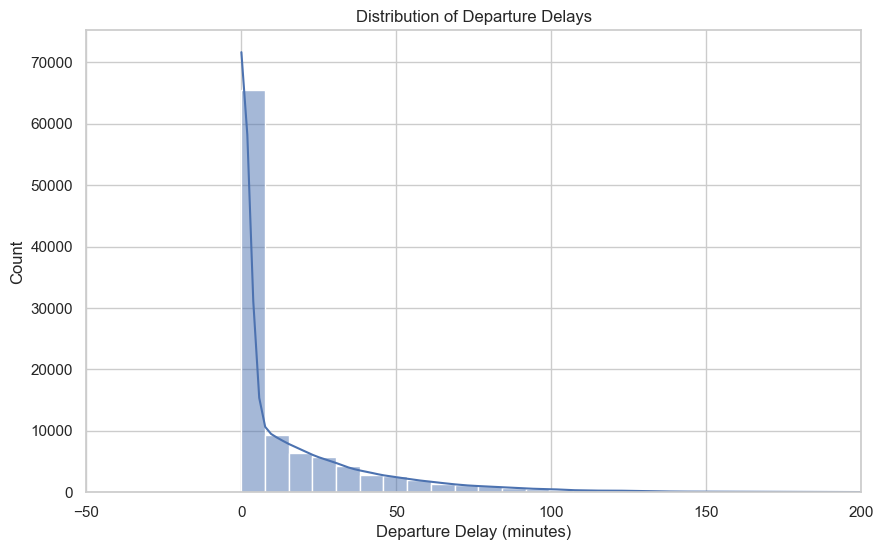

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['DepDelay'], bins=50, kde=True)
plt.title('Distribution of Departure Delays')
plt.xlabel('Departure Delay (minutes)')
plt.xlim(-50, 200) # Limit x-axis to focus on common delays
plt.show()

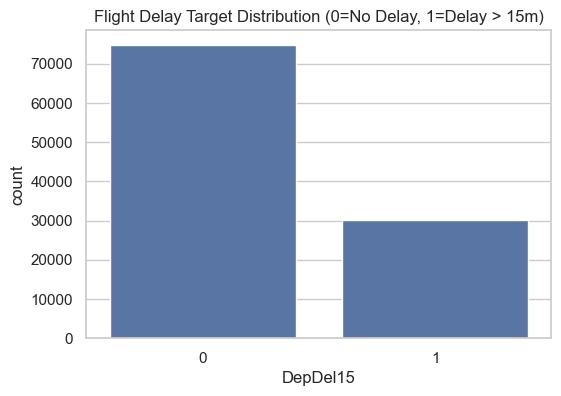

DepDel15
0    0.712514
1    0.287486
Name: proportion, dtype: float64


In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='DepDel15', data=df)
plt.title('Flight Delay Target Distribution (0=No Delay, 1=Delay > 15m)')
plt.show()

print(df['DepDel15'].value_counts(normalize=True))

### Carrier Analysis

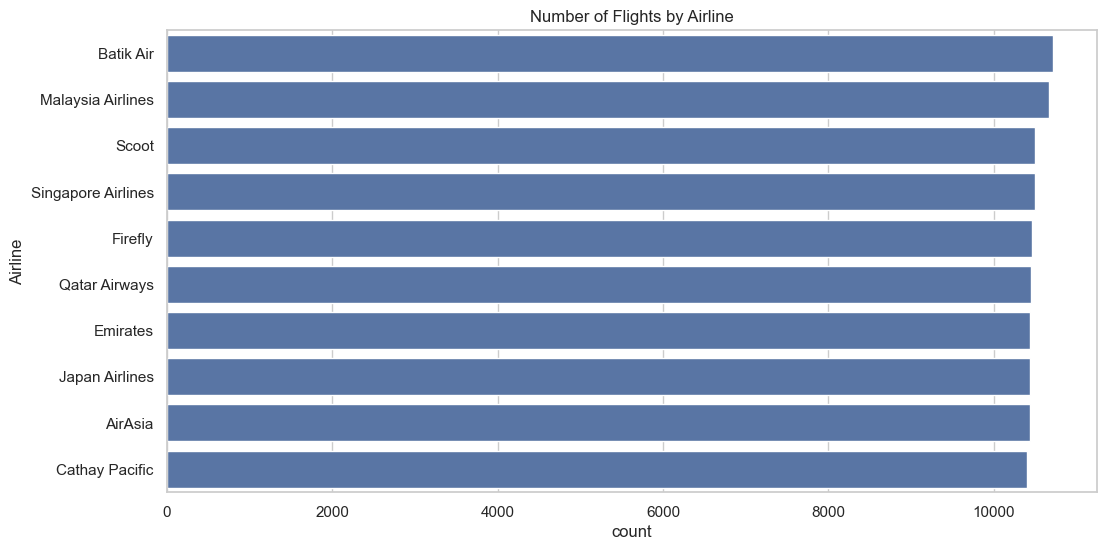

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Airline', data=df, order=df['Airline'].value_counts().index)
plt.title('Number of Flights by Airline')
plt.show()

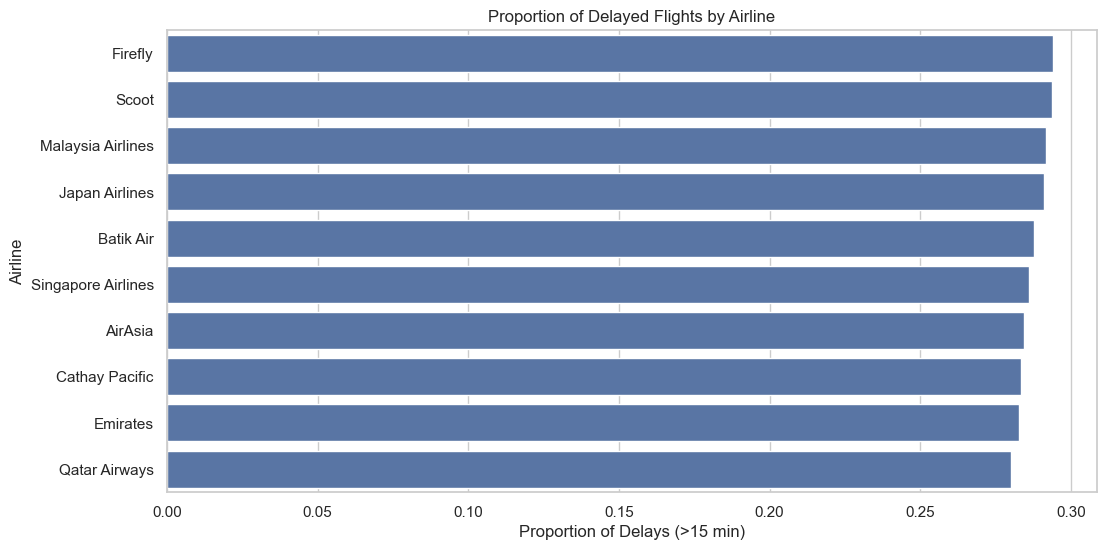

In [10]:
airline_delay = df.groupby('Airline')['DepDel15'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=airline_delay.values, y=airline_delay.index)
plt.title('Proportion of Delayed Flights by Airline')
plt.xlabel('Proportion of Delays (>15 min)')
plt.show()

### Time Analysis

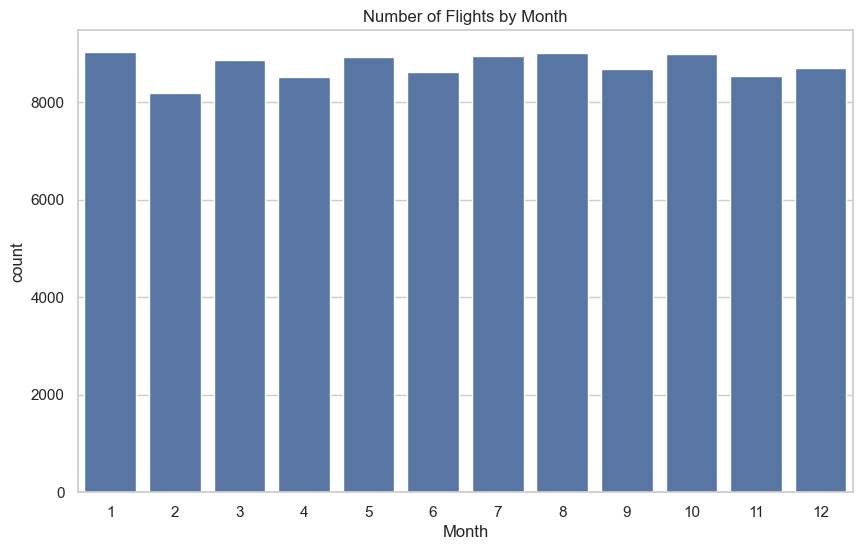

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Month', data=df)
plt.title('Number of Flights by Month')
plt.show()

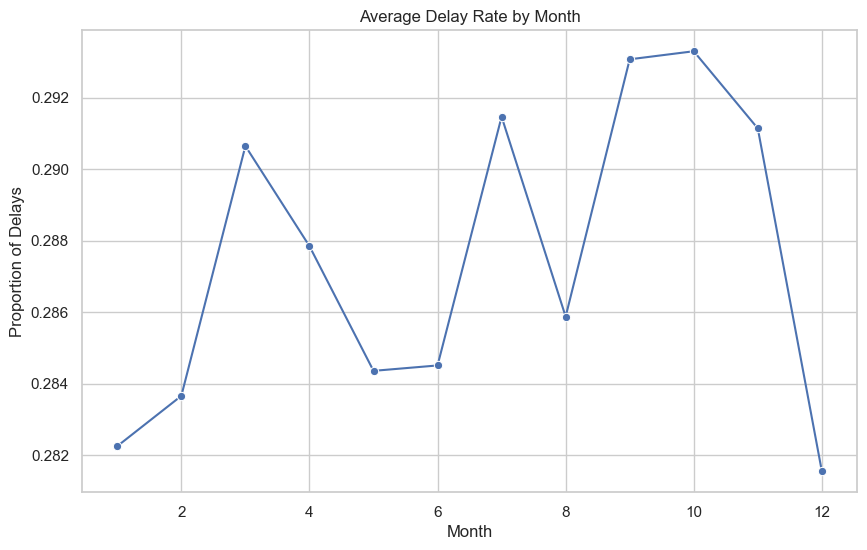

In [12]:
monthly_delay = df.groupby('Month')['DepDel15'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_delay.index, y=monthly_delay.values, marker='o')
plt.title('Average Delay Rate by Month')
plt.ylabel('Proportion of Delays')
plt.show()

### Route Analysis

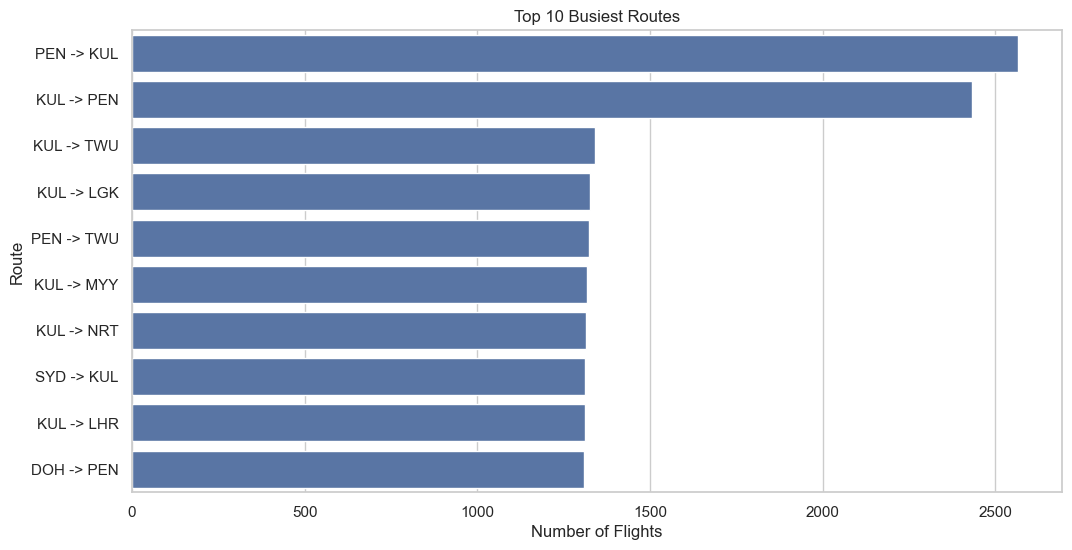

In [13]:
df['Route'] = df['Origin'] + ' -> ' + df['Dest']
top_routes = df['Route'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_routes.values, y=top_routes.index)
plt.title('Top 10 Busiest Routes')
plt.xlabel('Number of Flights')
plt.show()

### Cancellation Analysis

Cancellation Rate:
 Cancelled
0    0.9896
1    0.0104
Name: proportion, dtype: float64


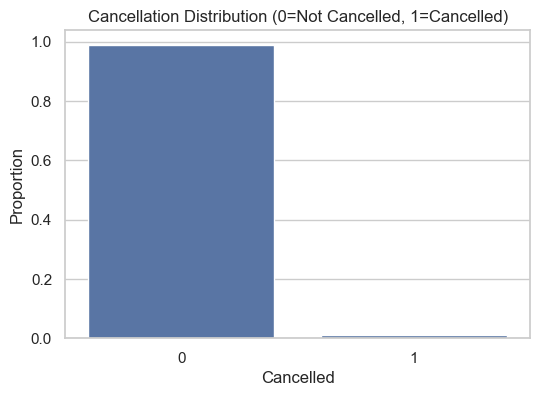

In [14]:
cancelled_counts = df['Cancelled'].value_counts(normalize=True)
print("Cancellation Rate:\n", cancelled_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=cancelled_counts.index, y=cancelled_counts.values)
plt.title('Cancellation Distribution (0=Not Cancelled, 1=Cancelled)')
plt.ylabel('Proportion')
plt.show()

### Correlation Analysis

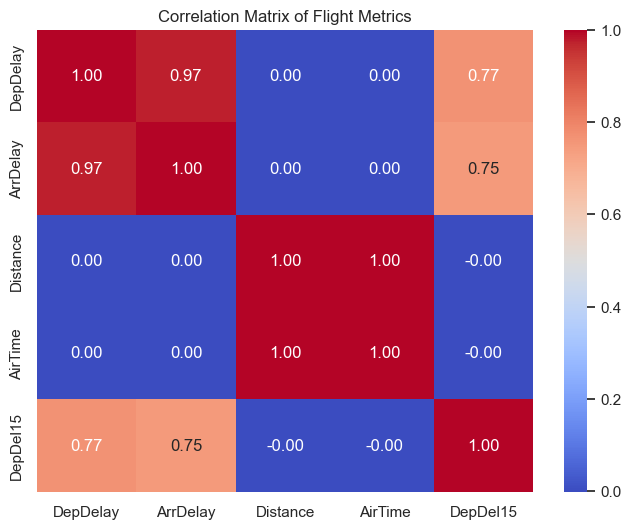

In [15]:
numeric_cols = ['DepDelay', 'ArrDelay', 'Distance', 'AirTime', 'DepDel15']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Flight Metrics')
plt.show()

## 5. Model Training

In [16]:
from IPython.display import display

# 1. Define target and features
target = 'DepDel15'
features = [
    'Month',
    'DayOfWeek',
    'CRSDepTime',        # Scheduled Departure Time
    'Operating_Airline', # Unique Carrier Code
    'Origin',            # Origin Airport Code
    'Dest',              # Destination Airport Code
    'Distance'           # Distance
]

categorical_features = ['Operating_Airline', 'Origin', 'Dest']

# 2. Clean the data for training
print(f"Original size: {df.shape[0]} rows")
df_train = df.dropna(subset=features + [target])
print(f"Size after dropping missing values: {df_train.shape[0]} rows")

# 3. Prepare X and y
X = df_train[features].copy()
y = df_train[target]

# 4. Encode categorical features
encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value', 
    unknown_value=-1,
    dtype=int
)

X[categorical_features] = encoder.fit_transform(X[categorical_features])

print("Data prepared and encoded.")
display(X.head())

Original size: 105000 rows
Size after dropping missing values: 105000 rows


Data prepared and encoded.


,Month,DayOfWeek,CRSDepTime,Operating_Airline,Origin,Dest,Distance
0,7,5,637,0,10,17,792
1,12,2,752,5,13,10,6128
2,4,5,918,9,21,10,1296
3,6,6,1615,8,14,10,920
4,2,6,1229,9,16,3,4736


In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Initialize the LightGBM Classifier
model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=100,
    n_jobs=-1
)

# Train the model
print("Starting model training...")
model.fit(X_train, y_train, 
          categorical_feature=categorical_features
         )

print("Model training complete.")

Starting model training...
[LightGBM] [Info] Number of positive: 24113, number of negative: 59887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.287060 -> initscore=-0.909708
[LightGBM] [Info] Start training from score -0.909708


Model training complete.


In [18]:
# Make predictions on the test set
print("Making predictions...")
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("-" * 30)
print(f"Model Performance Metrics:")
print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("-" * 30)

Making predictions...
------------------------------
Model Performance Metrics:
Accuracy:  71.08%
Precision: 0.5000
Recall:    0.0005
F1-Score:  0.0010
------------------------------


In [19]:
# Save the trained model and encoder
os.makedirs('api', exist_ok=True)
joblib.dump(model, 'api/flight_delay_model.joblib')
joblib.dump(encoder, 'api/flight_data_encoder.joblib')

print("Model and encoder saved to api/ folder.")

Model and encoder saved to api/ folder.
